In [21]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

In [39]:
df=pd.read_excel('sales2.xlsx')

# Create week var
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["week_nu"] = df["Order Date"].dt.year.astype(str) + 'W' + df['Week'].astype(str)

sumdf=pd.DataFrame(df.groupby(["Description", "week_nu"]).agg({'Order Date':'last', 'QTY':'sum'}).reset_index())
sumdf = sumdf.sort_values(by=['Description','Order Date'], ascending=True)
df_head = sumdf.set_index('Order Date').copy()

# Transposed DS for later use
df_head_trans = pd.pivot_table(df_head, values ='QTY', index =['Description'],
                         columns =['week_nu'], aggfunc = np.sum)


df_head_trans.tail(5)

week_nu,2021W1,2021W10,2021W11,2021W12,2021W13,2021W14,2021W2,2021W3,2021W4,2021W5,...,2022W18,2022W19,2022W20,2022W21,2022W22,2022W23,2022W24,2022W25,2022W26,2022W27
Description,,,,,,,,,,,,,,,,,,,,,
Pasta Pizza Sauce 325g,20,2560,2220,2060,2320,2360,1480,1540,2260,3040,...,2600,2940,2560,3020,2940,1860,1940,2760,2360,2996
Veg Mayo Original 100g,96,10608,9884,7680,11280,13056,7296,11664,11904,12912,...,11712,11176,10704,11184,12827,10009,4860,8544,11184,11219


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17468D+00    |proj g|=  1.62107D-01

At iterate    5    f=  4.12152D+00    |proj g|=  5.84740D-03

At iterate   10    f=  4.12080D+00    |proj g|=  3.62545D-04

At iterate   15    f=  4.12077D+00    |proj g|=  1.36139D-03

At iterate   20    f=  4.11192D+00    |proj g|=  8.17721D-03

At iterate   25    f=  4.10510D+00    |proj g|=  4.34723D-03

At iterate   30    f=  4.10403D+00    |proj g|=  3.80480D-03


 This problem is unconstrained.



At iterate   35    f=  4.10385D+00    |proj g|=  1.07556D-03

At iterate   40    f=  4.10380D+00    |proj g|=  1.51304D-04

At iterate   45    f=  4.10380D+00    |proj g|=  3.98955D-04

At iterate   50    f=  4.10379D+00    |proj g|=  1.23345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   1.233D-04   4.104D+00
  F =   4.1037921366210686     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


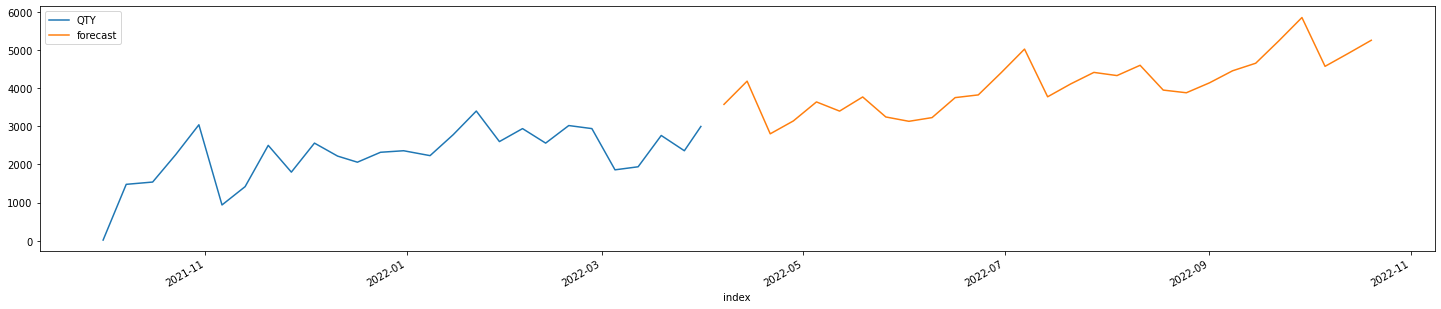

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19897D+00    |proj g|=  7.27571D-01

At iterate    5    f=  4.91072D+00    |proj g|=  1.53016D-02

At iterate   10    f=  4.90544D+00    |proj g|=  9.13095D-04

At iterate   15    f=  4.90539D+00    |proj g|=  1.37174D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.583D-05   4.905D+00
  F =   4.9053865043906724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


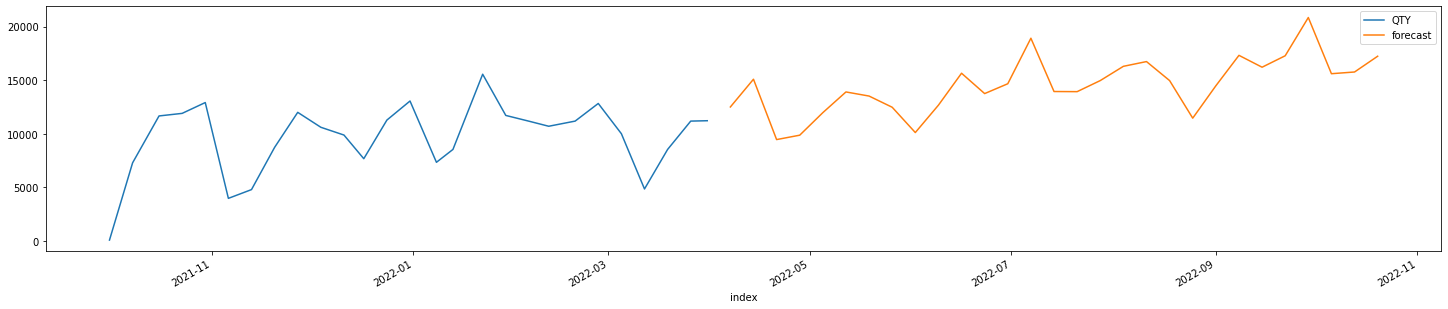

In [38]:
# List of items
sku_list = df_head.Description.unique()
df_forecast = pd.DataFrame([])

for i in sku_list:

    # Create a folder for graphs
    if not os.path.exists('Graphs'):
        os.makedirs('Graphs')

    df_sku = df_head.loc[df_head.Description==i, :]
    # df_sku.plot()
    # plt.title(i)

    model=sm.tsa.statespace.SARIMAX(df_sku['QTY'], order=(1, 1, 1),seasonal_order=(1,1,1,12))
    results=model.fit()

    # df_sku['forecast']=results.predict(start='2022-03-05',end ='2022-03-31',dynamic=True)
    # df_sku[['QTY','forecast']].plot(figsize=(25,5))
    # plt.title(i)
    # plt.savefig('./Graphs/' + i+'.png')

    # Add future dates
    future_dates=[df_sku.index[-1]+ DateOffset(weeks=x)for x in range(0,30)]
    future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_sku.columns)
    future_df=pd.concat([df_sku,future_datest_df])
       
    # Forecasts
    future_df = future_df.reset_index()
    future_df["forecast"] = results.forecast(steps=200)

    # final df appended
    _tmp = future_df.copy()
    _tmp['Description'] = i
    _tmp.loc[_tmp.forecast.isna(), 'forecast'] = _tmp['QTY']
    # _tmp.loc[_tmp.week_nu.isna(), 'week_nu'] = _tmp['index'].dt.week
    df_forecast = df_forecast.append(_tmp)

    # Plot
    future_df = future_df.set_index("index")
    future_df[['QTY', 'forecast']].plot(figsize=(25, 5))
    plt.savefig('./Graphs/' + i+'.jpeg', bbox_inches='tight', transparent=False, dpi=300)
    plt.show()

df_forecast.to_csv("./Graphs/forecasted_data.csv", index=False)